# British Airways - Customer Reviews Sentiment Analysis
*British Airways (BA) is the flag carrier airline of the United Kingdom (UK). Every day, thousands of BA flights arrive to and depart from the UK, carrying customers across the world. Whether it’s for holidays, work or any other reason, the end-to-end process of scheduling, planning, boarding, fuelling, transporting, landing, and continuously running flights on time, efficiently and with top-class customer service is a huge task with many highly important responsibilities.*


# Business Objective
* Customers who book a flight with BA will experience many interaction points with the BA brand. Understanding a customer's feelings, needs, and feedback is crucial for any business, including BA.

* Our goal is to examine how customers are communicating their positive and negative experiences about the airline. What are the attributes that customers are considering while travelling with an airline. 

* With this decision-makers can understand which elements of their service influence more in forming a positive review or improves airline brand image.

## Import required Libraries

In [ ]:
#!pip install matplotlib==3.4
#!pip install pyarrow
#!pip install fastparquet

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import re
import string

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


import warnings
warnings.filterwarnings('ignore')

## Import the dataset

In [ ]:
#Reading the dataset
df = pd.read_csv('/content/BA_reviews.csv')
df.head()

,Date,Reviews,Rating,Class,Country
0,9th January 2023,Flew ATL to LHR 8th Jan 2023. Was unlucky enou...,4.0,Economy Class,United Kingdom
1,8th January 2023,Great thing about British Airways A380 is the ...,5.0,Economy Class,United Kingdom
2,6th January 2023,"The staff are friendly. The plane was cold, we...",1.0,Economy Class,Canada
3,2nd January 2023,Probably the worst business class experience I...,1.0,Business Class,United States
4,2nd January 2023,"Definitely not recommended, especially for bus...",2.0,Business Class,United States


## Data Understanding & Cleaning

In [ ]:
#Summary of the overall dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3454 non-null   object 
 1   Reviews  3454 non-null   object 
 2   Rating   3449 non-null   float64
 3   Class    3453 non-null   object 
 4   Country  3452 non-null   object 
dtypes: float64(1), object(4)
memory usage: 135.0+ KB


In [ ]:
#Checking the count of duplicate rows
df.duplicated(subset=['Reviews', 'Rating', 'Class', 'Country']).sum()

12

In [ ]:
#Dropping the duplicate rows
df.drop_duplicates(inplace=True, subset=['Reviews', 'Rating', 'Class', 'Country'])

In [ ]:
#ReChecking if any duplicate values
df.duplicated(subset=['Reviews', 'Rating', 'Class', 'Country']).sum()

0

In [ ]:
#Checking the null values in dataset
df.isnull().sum()

Date       0
Reviews    0
Rating     5
Class      1
Country    2
dtype: int64

In [ ]:
#Dropping the null values and reset the index
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)

In [ ]:
#Convert the data types of column to correct format
df['Date'] = pd.to_datetime(df['Date'])
df['Rating'] = df['Rating'].astype('int16')

#Checking the summary after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     3434 non-null   datetime64[ns]
 1   Reviews  3434 non-null   object        
 2   Rating   3434 non-null   int16         
 3   Class    3434 non-null   object        
 4   Country  3434 non-null   object        
dtypes: datetime64[ns](1), int16(1), object(3)
memory usage: 114.1+ KB


In [ ]:
#Reviewing a particular review
df['Reviews'][3]

'Probably the worst business class experience I\'ve ever had on an airline. Just a few of the issues: Required to purchase seats on international (Club World) business class. This was not made known during the ticket purchase process and cost me an additional $600 on a single leg (LHR-LAX) for a family of four. Given the very strange business class seating layout on BA A380s, leaving the seat selection to change could have been disastrous for my family. Ridiculously long boarding times on even small aircraft. On my VIE-LHR leg, the boarding time for the A320 was over 50 minutes long, leading to a delayed departure. There was no urgency on the part of staff to speed up the boarding times. Severe overcrowding in the boarding area in satellite C of terminal 5 at Heathrow. Boarding staff would not allow passengers to enter the roped off queue area before boarding (I have no idea why not) and so crowding was extreme. The overall boarding area was far too small for an A380, and I believe thi

In [ ]:
#Download & update the corpus
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#Object Instantiation
stop_words = nltk.corpus.stopwords.words('english')
stpw = ENGLISH_STOP_WORDS
wnl = WordNetLemmatizer()

In [ ]:
#Appending the list to include other unncessary words
new_stopwords = ["ba","flight", "british","airway", "airline","airways", "airlines","plane", "told","also","passenger", "passengers","london", "heathrow", "aircraft", "via",
                "could","even", "would", "airport", "will", "airport","now", "gatwick", "u", "atl", "lhr", "jan", "verified review", "verify review", "not verify", "not verified"]

stop_words.extend(new_stopwords)

In [ ]:
#Defined a function for cleaning reviews in the data set

def clean_text(text): 

    text = str(text).lower() #Lower case each word

    text = re.sub(r'\w*\d\w*', '', str(text)).strip() #Removing numeric attached with words 
    
    text = re.sub("[\d]+", "", str(text))  # Removing the strings which contains unnecessary digits in data
    
    text = re.sub(r"won\'t", "will not", str(text))      # Replace contraction words
    text = re.sub(r"can\'t", "can not", str(text))      # Replace contraction words
    text = re.sub(r"ca n\'t", "can not", str(text))      # Replace contraction words
    text = re.sub(r"wo n\'t", "will not", str(text))      # Replace contraction words
    text = re.sub(r"\'t've", " not have", str(text))     # Replace contraction words
    text = re.sub(r"\'d've", " would have", str(text))   # Replace contraction words
    text = re.sub(r"\'cause", " because", str(text))     # Replace contraction words
    
    text = re.sub(r"n\'t", " not", str(text))     # Replace contraction words
    text = re.sub(r"\'re", " are", str(text))     # Replace contraction words
    text = re.sub(r"\'s", " is", str(text))       # Replace contraction words
    text = re.sub(r"\'d", " would", str(text))    # Replace contraction words
    text = re.sub(r"\'ll", " will", str(text))    # Replace contraction words
    text = re.sub(r"\'t", " not", str(text))      # Replace contraction words
    text = re.sub(r"\'ve", " have", str(text))    # Replace contraction words
    text = re.sub(r"\'m", " am", str(text))       # Replace contraction words

    text = re.sub(r"n\'t", " not", str(text))     # Replace contraction words
    text = re.sub(r"\'re", " are", str(text))     # Replace contraction words
    text = re.sub(r"\'s", " is", str(text))       # Replace contraction words
    text = re.sub(r"\'d", " would", str(text))    # Replace contraction words
    text = re.sub(r"\'ll", " will", str(text))    # Replace contraction words
    text = re.sub(r"\'t", " not", str(text))      # Replace contraction words
    text = re.sub(r"\'ve", " have", str(text))    # Replace contraction words
    text = re.sub(r"\'m", " am", str(text))       # Replace contraction words
    
    text = re.sub(r'[^\w\s]', " ", str(text))    # Removing white spaces and returning only alpha characters
    
    text = text.translate(str.maketrans('','',string.punctuation)) # Remove Punctuations
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) # Remove Punctuations
    
    text = ' '.join( [w for w in text.split() if len(w)>1] ) # Removing an unnecessary single character from sentences

    text = text = re.sub(r'\bNot Verified\b', '', str(text)).strip() #Removing an unnecessary characters from sentences

    text = text = re.sub(r'\bTrip Verified\b', '', str(text)).strip() #Removing an unnecessary characters from sentences
  
    text = text.split() #Splitting each word
    
    text = " ".join([word for word in text if word not in stop_words]) #Removing stopwords, white spaces, making words lower and joining into text
    
    #text = text.split() # Splitting each word
    
    #text = " ".join([word for word in text if word not in stpw]) # Removing extra stopwords if any
    
    text = nltk.word_tokenize(text)  # Tokenising each words 
       
    text = " ".join([wnl.lemmatize(w, 'v') for w in text])  # Applying Lemmatization

    text = ' '.join(dict.fromkeys(text.split())) #Remove duplicate words from a sentence
      
    return text

In [ ]:
#Original Review before cleaning
df['Reviews'][0]

'Flew ATL to LHR 8th Jan 2023. Was unlucky enough to be on board a 23 year old 777. Refit gave it a decent IFE screen and the seat looked decent. Although combine the IFE with the cheap and nasty earbuds, and any movie can be ruined. Headrest was great, just a pity little padding is used on the seat as my Wife and I were very uncomfortable. The leg room in general is poor, especially when passengers keep their seat reclined from start to finish. Zero room. Aircraft was tired. Rubber spacers falling out, silicone sealer falling apart in the toilets. Toilet seats old, stained. Rubber on arm rest was hanging off. No post take off drinks/snacks offered.  Meal was sent out after a couple of hours. Was poor. Chicken cubes that reminded me of dog food, mashed potatoes that were purified within an inch of their life. Stale rock hard roll, salad which was rice and carrots?! Dried crackers with no cheese. Kids meal was just as sad. Tiny leaf salad with enough dressing to refloat a shipwreck. Cof

In [ ]:
#Review after cleaning
clean_text(df['Reviews'][0])

'fly unlucky enough board year old refit give decent ife screen seat look although combine cheap nasty earbuds movie ruin headrest great pity little pad use wife uncomfortable leg room general poor especially keep recline start finish zero tire rubber spacers fall silicone sealer apart toilets toilet stain arm rest hang post take drink snack offer meal send couple hours chicken cub remind dog food mash potatoes purify within inch life stale rock hard roll salad rice carrots dry crackers cheese kid sad tiny leaf dress refloat shipwreck coffee creamer adults bagel egg hot tasty green wrap spinach onions mix service grunt cram land remote stand endure bus terminal opinion terrible disappoint one member cabin crew everything else average'

In [ ]:
#Making a copy of original dataframe
df1 = df.copy()

In [ ]:
#Applying the clean_text function on entire dataset
df1['Clean_Reviews'] = df1['Reviews'].apply(lambda x: clean_text(x))
df1.head()

,Date,Reviews,Rating,Class,Country,Clean_Reviews
0,2023-01-09,Flew ATL to LHR 8th Jan 2023. Was unlucky enou...,4,Economy Class,United Kingdom,fly unlucky enough board year old refit give d...
1,2023-01-08,Great thing about British Airways A380 is the ...,5,Economy Class,United Kingdom,great thing economy section upstairs get allow...
2,2023-01-06,"The staff are friendly. The plane was cold, we...",1,Economy Class,Canada,staff friendly cold shiver give light blanket ...
3,2023-01-02,Probably the worst business class experience I...,1,Business Class,United States,probably worst business class experience ever ...
4,2023-01-02,"Definitely not recommended, especially for bus...",2,Business Class,United States,definitely recommend especially business class...


In [ ]:
#Comparing the length of reviews before & after text preprocessing
df1['Old_len'] = df1['Reviews'].apply(len)
old_len = df1['Old_len'].sum()

df1['New_len'] = df1['Clean_Reviews'].apply(len)
new_len = df1['New_len'].sum()

print('\033[1m'+ "Total Review Length Comparison" + '\033[0m')
print('=======================================')
print("Before Text Preprocessing : {}".format(old_len))
print('---------------------------------------')
print("After Text Preprocessing  :{}".format(new_len))
print('=======================================')

Total Review Length Comparison
Before Text Preprocessing : 3054586
---------------------------------------
After Text Preprocessing  :1395048


In [ ]:
#Saving the cleaned dataframe
df1.drop('Reviews', axis=1, inplace=True)
df1 = df1[['Date', 'Clean_Reviews', 'Rating', 'Class', 'Country']]
df1.head()
df1.to_parquet('Cleaned_data.parquet')
#df1.to_csv('Cleaned_data.csv', index=False)

**Note:**
* We have observed and dropped the duplicate, missing/null values from data.
* We have converted the data into their correct data dtype format.
* Defined a function for cleaning the unnecessary characters, letters, numbers from reviews using regular expression (re) module.
* Saved the dataframe into the parquet file for quickly access, less space consumption and fast retrieval.

*Let's, try to explore data further, visualise and draw inferences.*   

## Exploratory Data Analysis (EDA) 

In [ ]:
#Reading the cleaned dataframe
data = pd.read_parquet('/content/Cleaned_data.parquet')
data.head()

,Date,Clean_Reviews,Rating,Class,Country
0,2023-01-09,fly unlucky enough board year old refit give d...,4,Economy Class,United Kingdom
1,2023-01-08,great thing economy section upstairs get allow...,5,Economy Class,United Kingdom
2,2023-01-06,staff friendly cold shiver give light blanket ...,1,Economy Class,Canada
3,2023-01-02,probably worst business class experience ever ...,1,Business Class,United States
4,2023-01-02,definitely recommend especially business class...,2,Business Class,United States


In [ ]:
#Checking the shape of dataset
data.shape

(3434, 5)

In [ ]:
#Statistical description of categorical data
data.describe(include='O')

,Clean_Reviews,Class,Country
count,3434,3434,3434
unique,3430,4,69
top,fly back milan lin mist pilot actual character...,Economy Class,United Kingdom
freq,2,1771,2184


In [ ]:
#Statistical description of numerical data
data.describe()

,Rating
count,3434.000000
mean,4.838672
std,3.160003
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,10.000000


In [ ]:
#Checking the unique rating values 
sorted(data['Rating'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
#Count of Reviews provided by customers year wise
gg = data.groupby(data['Date'].dt.strftime('%Y'))['Clean_Reviews'].count().reset_index()
gg.rename(columns={'Date':'Year', 'Clean_Reviews':'Total_Count_Reviews'}, inplace=True)
gg

,Year,Total_Count_Reviews
0,2011,2
1,2012,12
2,2014,459
3,2015,728
4,2016,570
5,2017,572
6,2018,324
7,2019,356
8,2020,104
9,2021,87


In [ ]:
#Year wise analysis of average ratings
ff = data.groupby(data['Date'].dt.strftime('%Y'))['Rating'].mean().round(2).reset_index()
ff.rename(columns={'Date':'Year', 'Rating':'Avg_Rating'}, inplace=True)

ff

,Year,Avg_Rating
0,2011,4.50
1,2012,5.83
2,2014,5.95
3,2015,5.44
4,2016,4.99
5,2017,3.85
6,2018,4.32
7,2019,4.76
8,2020,4.34
9,2021,4.30


In [ ]:
#Top 10 countries with total number of reviews and their average ratings
a = data.groupby(data['Country']).count().sort_values('Clean_Reviews', ascending=False).reset_index().head(10)
a.drop(columns=a.iloc[:, 2:], axis=1, inplace=True)
a.rename(columns={'Date': 'Total_Reviews'}, inplace=True)
a

,Country,Total_Reviews
0,United Kingdom,2184
1,United States,360
2,Australia,148
3,Canada,106
4,Germany,59
5,South Africa,38
6,Switzerland,37
7,Ireland,37
8,Netherlands,31
9,Singapore,27


In [ ]:
#Above Top 10 countries with their average ratings 
b = data.groupby(data['Country']).mean()['Rating'].round(2).reset_index()
c = a.merge(b, on='Country', how='left')
c.rename(columns={'Rating': 'Avg_Ratings'}, inplace=True)
c.sort_values(ascending=False, by='Avg_Ratings', ignore_index=True)

,Country,Total_Reviews,Avg_Ratings
0,South Africa,38,5.47
1,Netherlands,31,5.42
2,United Kingdom,2184,4.88
3,Canada,106,4.86
4,Australia,148,4.66
5,Ireland,37,4.46
6,Switzerland,37,4.41
7,Singapore,27,4.30
8,United States,360,4.20
9,Germany,59,4.07


In [ ]:
c

,Country,Total_Reviews,Avg_Ratings
0,United Kingdom,2184,4.88
1,United States,360,4.20
2,Australia,148,4.66
3,Canada,106,4.86
4,Germany,59,4.07
5,South Africa,38,5.47
6,Switzerland,37,4.41
7,Ireland,37,4.46
8,Netherlands,31,5.42
9,Singapore,27,4.30


In [ ]:
#Count of Customers travelled with following Class
r = data['Class'].value_counts().reset_index()
r.rename(columns={'Class':'Count', 'index':'Class'}, inplace=True)
r

,Class,Count
0,Economy Class,1771
1,Business Class,1117
2,Premium Economy,340
3,First Class,206


In [ ]:
#Class wise average ratings by customers
d = data.groupby(data['Class']).mean()['Rating'].round(2).reset_index()
d.rename(columns={'Rating': 'Avg_Ratings'}, inplace=True)
d.sort_values(ascending=False, by='Avg_Ratings', ignore_index=True)
t = r.merge(d, on='Class', how='right')
t.sort_values(ascending=False, by='Count', ignore_index=True)

,Class,Count,Avg_Ratings
0,Economy Class,1771,4.46
1,Business Class,1117,5.26
2,Premium Economy,340,4.90
3,First Class,206,5.69


In [ ]:
#Defining a function for Review Distribution
def rev_dist(text):    
    if text >= 7:
        return 'Positive'
    elif text < 5 :
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
#Making a copy of original dataframe
data1 = data.copy()

In [ ]:
#Applying the function to entire dataset
data1['Polarity'] = data1['Rating'].apply(rev_dist) 
data1.head()

,Date,Clean_Reviews,Rating,Class,Country,Polarity
0,2023-01-09,fly unlucky enough board year old refit give d...,4,Economy Class,United Kingdom,Negative
1,2023-01-08,great thing economy section upstairs get allow...,5,Economy Class,United Kingdom,Neutral
2,2023-01-06,staff friendly cold shiver give light blanket ...,1,Economy Class,Canada,Negative
3,2023-01-02,probably worst business class experience ever ...,1,Business Class,United States,Negative
4,2023-01-02,definitely recommend especially business class...,2,Business Class,United States,Negative


**Note:**
* To-date average overall ratings of the airline is at 4.8/10.
* For the year 2022, the average rating was 4/10.
* Past 3 years, ratings have dipped continously, significant reason could be the pandemic, strict lockdowns and travel restrictions.  
* The top 5 frequent travellers belong from UK, US, Australia, Canada & Germany.
* Customers travelled mostly with BA's Economy class and Business Class accounting for 84% overall.  

*Let's, try to visualise and draw inferences.*   

### Data Visualisation

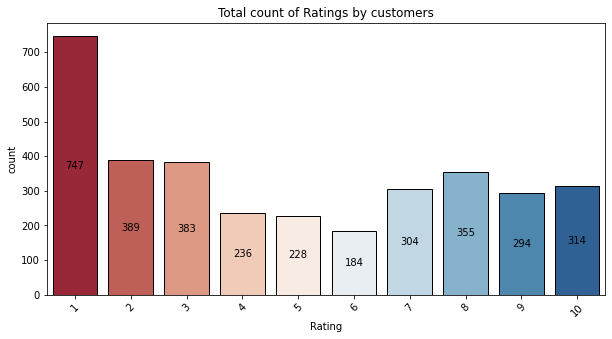

In [ ]:
#Visualizing the unique values of ratings
plt.figure(figsize=(10,5))
ax = sns.countplot(data = data1, x = 'Rating', edgecolor='black', linewidth=1, palette='RdBu')

for i in ax.containers:
    ax.bar_label(i, label_type='center')
    
plt.title('Total count of Ratings by customers')
plt.xticks(rotation='45')
plt.show()

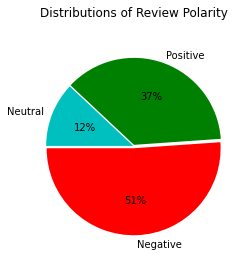

In [ ]:
#Checking the distribution of Polarity
plt.figure(figsize=(8,4))
plt.pie(data1['Polarity'].value_counts(), explode=(0.025,0.015, 0.005), 
            labels=['Negative', 'Positive', 'Neutral'], colors=["r","g", "c"],
            autopct="%1.f%%", startangle=180)

plt.title("Distributions of Review Polarity\n")
plt.show()

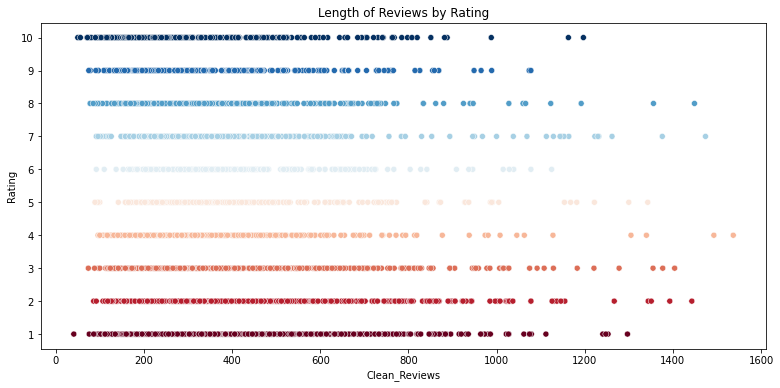

In [ ]:
#Visualizing the length of words in a review for all the rating
plt.figure(figsize=(13,6))
sns.scatterplot(x=data1['Clean_Reviews'].apply(len), y=data1['Rating'], data=data1, palette='RdBu', hue='Rating', legend=False)
plt.title('Length of Reviews by Rating')
plt.yticks([1,2,3,4,5,6,7,8,9,10])
plt.show()

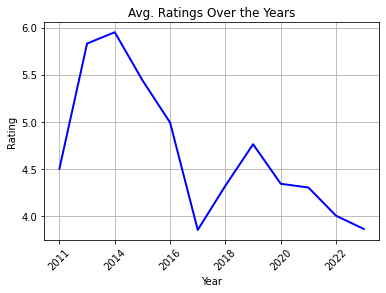

In [ ]:
#Visualizing the year wise avg. ratings
ff.plot(x='Year', legend=False, linewidth=2.0, color='blue')
plt.xticks(rotation='45')
plt.title('Avg. Ratings Over the Years')
plt.ylabel('Rating')
plt.grid()
plt.show()

In [ ]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1200, height = 900, max_words=250,
                          background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (13, 6), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

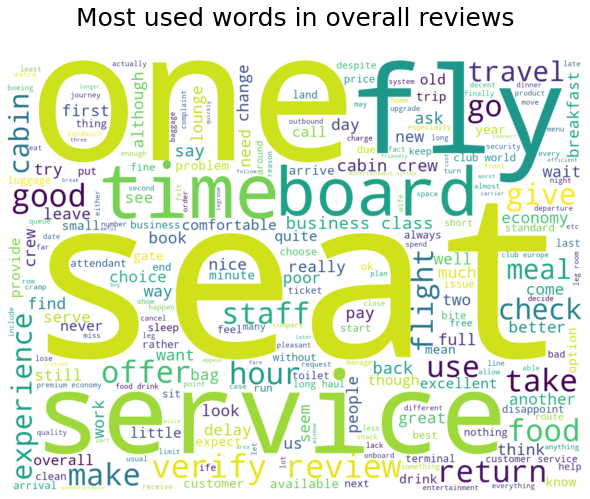

In [ ]:
#Plotting the wordcloud for overall reviews
wordCloud_generator(data=data['Clean_Reviews'], title="Most used words in overall reviews\n")

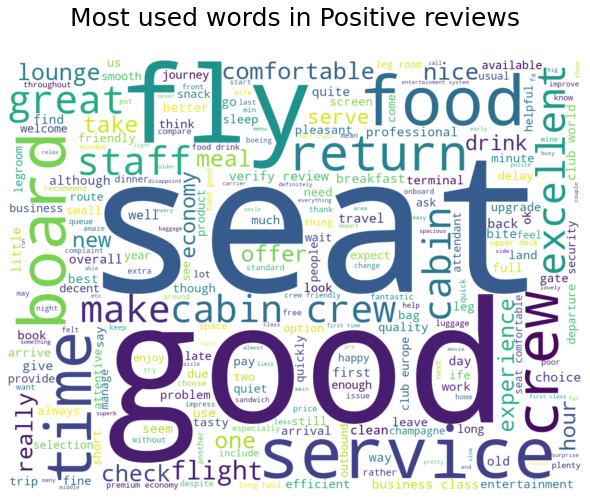

In [ ]:
#Plotting the wordcloud for overall reviews
wordCloud_generator(data=data1[data1['Rating']>7]['Clean_Reviews'], title="Most used words in Positive reviews\n")

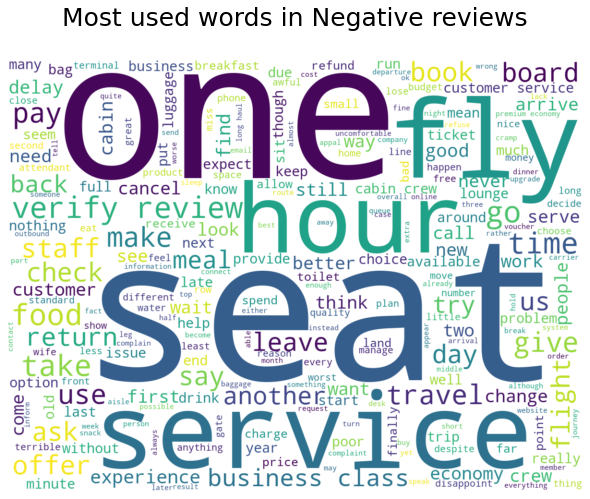

In [ ]:
#Plotting the wordcloud for overall reviews
wordCloud_generator(data=data1[data1['Rating']<4]['Clean_Reviews'], title="Most used words in Negative reviews\n")

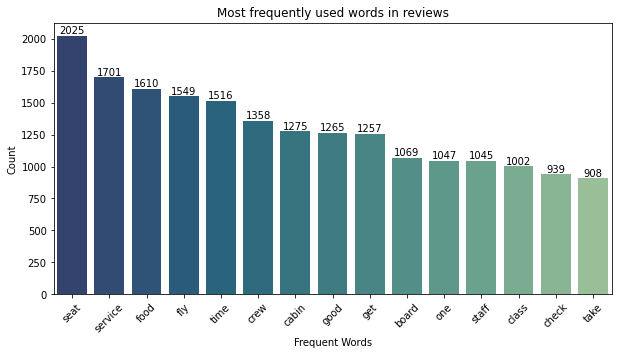

In [ ]:
#Visualising the most frequency of word count
reviews = " ".join(data1.Clean_Reviews)
words = reviews.split(" ")
fr = FreqDist(words).most_common(15)
freq_words = pd.Series(dict(fr))

plt.figure(figsize=(10,5))
ax = sns.barplot(x = freq_words.index, y=freq_words.values, palette='crest_r')

for i in ax.containers:
    ax.bar_label(i)

plt.xlabel('Frequent Words')
plt.ylabel('Count')    
plt.title('Most frequently used words in reviews')
plt.xticks(rotation='45')
plt.show()

**Note:**
* As we have observed, 51% reviews are negative which are rated between 1-4 on a scale of 10; 37% reviews are positive which are rated 7-10 & remaining are neutral reviews.
* The length of reviews for negative feedbacks are greater than positives. 
* Post year 2014, the average ratings have dropped significantly over the years.
* The most frequent words used for positive feedbacks are good, excellent, food, seat, comfortable, cabin crew, staff, board, nice, etc.  
* The most frequent words used for negative feedbacks are hour, service, fly, seat, time, travel, delay, poor, disappoint, etc.

*Let's, go ahead with sentiment analysis of reviews.*   

VADER SENTIMENT ANALYSIS

#### Using NLTK's VADER - Sentiment Intensity Analyzer  
* Vader is a lexicon and rule based sentiment analysis tool specifically calibrated to sentiments most commonly expressed on social media platforms. When calculating a polarity score Vader outputs four metrics: compound, negative, neutral and positive. The compound score calculates the sum of all lexicon ratings which is normalized between -1 (most negative) and +1 (most positive).

In [ ]:
##Object Instantiation
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#Defining a function for Sentiment Analysis
def fetch_sentiment_using_SIA(text):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = sia.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] or polarity_scores['compound']<0.6 else 'pos'

def SIA_score(text):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = sia.polarity_scores(text)
    return polarity_scores['compound']

In [ ]:
#Drawn a positive sample for testing the sentiment
data1['Clean_Reviews'][3431]

'ham purser address club name board little late leave time food good short overall excellent'

In [ ]:
#Testing the sample
sia.polarity_scores(df['Reviews'][3431])

{'neg': 0.0, 'neu': 0.712, 'pos': 0.288, 'compound': 0.872}

In [ ]:
#Drawn a negative sample for testing the sentiment
data1['Clean_Reviews'][3]

'probably worst business class experience ever issue require purchase seat international club world make know ticket process cost additional single leg lax family four give strange layout leave selection change disastrous ridiculously long board time small vie minutes lead delay departure urgency part staff speed severe overcrowd area satellite terminal allow enter rope queue idea crowd extreme overall far believe design build first deliver online check advance flight appear completely break urge repeatedly website email text upload covid document though end travel fill basic contact information documentation inform several hours later verify receive another message shop com page one direct attempt connect wifi indicate incorrect remain six land lounge europe often seriously furniture carpet finish wear dirty say food pretty good quality may redeem thing onboard beverage service average terrible might pre meal mid unlike offer take order attendants begin meals bring haphazardly shortly

In [ ]:
#Testing the sample
sia.polarity_scores(df['Reviews'][3])

{'neg': 0.109, 'neu': 0.881, 'pos': 0.01, 'compound': -0.9943}

In [ ]:
#Applying the VADER function to entire data
data1['Vader_sent'] = data1.Clean_Reviews.apply(lambda x: fetch_sentiment_using_SIA(x))
data1['Vader_Score'] = data1.Clean_Reviews.apply(lambda x: SIA_score(x))

In [ ]:
#Reviewing the data
data1[['Date','Clean_Reviews', 'Rating', 'Vader_sent', 'Vader_Score']]

,Date,Clean_Reviews,Rating,Vader_sent,Vader_Score
0,2023-01-09,fly unlucky enough board year old refit give d...,4,neg,-0.9612
1,2023-01-08,great thing economy section upstairs get allow...,5,pos,0.7964
2,2023-01-06,staff friendly cold shiver give light blanket ...,1,neg,0.5574
3,2023-01-02,probably worst business class experience ever ...,1,neg,-0.9792
4,2023-01-02,definitely recommend especially business class...,2,pos,0.8519
...,...,...,...,...,...
3429,2012-08-29,toronto book emergency exit seat night home co...,7,neg,0.4588
3430,2012-08-29,business bkk first try back years fly many imp...,4,pos,0.6054
3431,2012-08-28,ham purser address club name board little late...,9,pos,0.7703
3432,2011-10-12,son work urge fly kansas city recommend join e...,5,pos,0.7506


Total Count of Sentiments

pos    54.542807
neg    45.457193
Name: Vader_sent, dtype: float64 



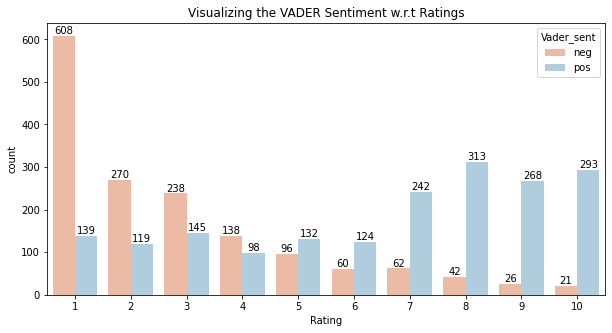

In [ ]:
#Visualizing the Vader Sentiment Analysis
plt.figure(figsize=(10,5))

plt.title("Visualizing the VADER Sentiment w.r.t Ratings")

ax = sns.countplot(data = data1 , x = 'Rating', hue = 'Vader_sent', palette='RdBu')

for i in ax.containers:
    ax.bar_label(i,)
        
print('Total Count of Sentiments\n')

print(data1['Vader_sent'].value_counts(['Vader_sent'])*100, '\n')

##### Note:
* As we can see, from above sentiment analysis visual almost 55% reviews are tagged as "Positive" using NLTK's VADER approach.
* SIA has managed to tag top ratings (7-10) as reviews with positive sentiment & low ratings (1-4) with negative sentiment respectively.
* We will try checking sentiment with other sentiment analysis techniques for reviews using nltk.

#### TextBlob
* TextBlob is built on top of NLTK and also it is very easy to use and can process the text in a few lines of code. Textblob can be used for complex analysis and working with textual data. When a sentence is passed into Textblob it gives two outputs, which are polarity and subjectivity. 
* Polarity is the output that lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment. Subjectivity is the output that lies within [0,1] and refers to personal opinions and judgments.

In [ ]:
#Defining a function for sentiment analysis
def fetch_sentiment_TxB(text):
    tb = TextBlob(text).sentiment[0]
    return 'neg' if tb < 0.11 else 'pos'

In [ ]:
#Applying the TextBlob to entire data
data1['TxtB_Polarity'] = data1['Clean_Reviews'].apply(lambda x: TextBlob(x).sentiment[0])

In [ ]:
#Reviewing the data
data1[['Clean_Reviews', 'Rating', 'TxtB_Polarity']]

,Clean_Reviews,Rating,TxtB_Polarity
0,fly unlucky enough board year old refit give d...,4,-0.122500
1,great thing economy section upstairs get allow...,5,0.011979
2,staff friendly cold shiver give light blanket ...,1,-0.022619
3,probably worst business class experience ever ...,1,-0.089658
4,definitely recommend especially business class...,2,-0.037255
...,...,...,...
3429,toronto book emergency exit seat night home co...,7,0.100000
3430,business bkk first try back years fly many imp...,4,-0.041667
3431,ham purser address club name board little late...,9,0.202083
3432,son work urge fly kansas city recommend join e...,5,0.277083


In [ ]:
#Drawn a positive sample for testing the sentiment
txt = TextBlob(data1['Clean_Reviews'][3433])

In [ ]:
#Testing the sample
txt.polarity

0.30606060606060603

In [ ]:
#Testing the sample
txt.sentiment_assessments

Sentiment(polarity=0.30606060606060603, subjectivity=0.44242424242424244, assessments=[(['new'], 0.13636363636363635, 0.45454545454545453, None), (['really', 'nice'], 0.6, 1.0, None), (['professional'], 0.1, 0.1, None), (['fresh'], 0.3, 0.5, None), (['overall'], 0.0, 0.0, None), (['good'], 0.7, 0.6000000000000001, None)])

In [ ]:
#Drawn a negative sample for testing the sentiment
txt2 = TextBlob(data1['Clean_Reviews'][2])

In [ ]:
#Testing the sample
txt2.polarity

-0.022619047619047615

In [ ]:
#Testing the sample
txt2.sentiment_assessments

Sentiment(polarity=-0.022619047619047615, subjectivity=0.5226190476190476, assessments=[(['friendly'], 0.375, 0.5, None), (['cold'], -0.6, 1.0, None), (['light'], 0.4, 0.7, None), (['enough'], 0.0, 0.5, None), (['basic'], 0.0, 0.125, None), (['vague'], -0.5, 0.5, None), (['main'], 0.16666666666666666, 0.3333333333333333, None)])

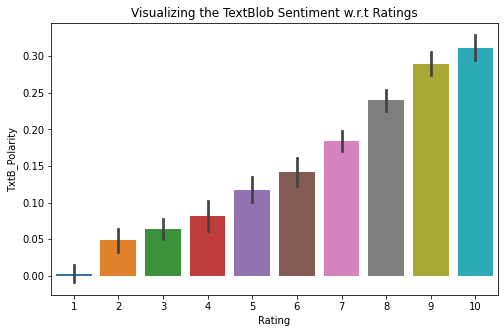

In [ ]:
#Visualizing the TextBlob Sentiment Analysis
plt.figure(figsize=(8,5))

ax = sns.barplot(data= data1, x = 'Rating', y = 'TxtB_Polarity')

plt.title("Visualizing the TextBlob Sentiment w.r.t Ratings")

plt.show()

##### Note:
* Negative reviews polarity scores is not fully negative but also positively low scored. Hence, it is difficult to interpret the positive & negative reviews.
* After testing two random samples, negative sample review is incorrectly tagged as positive using Text Blob.

#### Afinn Sentiment Analysis
* Afinn is the simplest yet popular lexicons used for sentiment analysis developed by Finn Årup Nielsen. It contains 3300+ words with a polarity score associated with each word.
* Afinn is a list of words rated for valence with an integer between minus five (negative) and plus five (positive). The comparative score is simply: sum of each token / number of tokens.

In [ ]:
#!pip install afinn

In [ ]:
# Emotion Lexicon - Affin
from afinn import Afinn

In [ ]:
#Object Instantiation
afn = Afinn()

In [ ]:
#Drawn a negative sample for testing the sentiment
nn = data1['Clean_Reviews'][3429]

In [ ]:
#Testing the negative sample
afn.score(nn)

-1.0

In [ ]:
#Drawn a positive sample for testing the sentiment
pp = data1['Clean_Reviews'][3433]

In [ ]:
#Testing the positive sample
afn.score(pp)

7.0

In [ ]:
#Applying afinn to dataset
data1['Afinn_score'] = data1['Clean_Reviews'].apply(lambda x: afn.score(x))

In [ ]:
#Reviewing the data
data1[['Clean_Reviews',  'Rating', 'Afinn_score']]

,Clean_Reviews,Rating,Afinn_score
0,fly unlucky enough board year old refit give d...,4,-16.0
1,great thing economy section upstairs get allow...,5,4.0
2,staff friendly cold shiver give light blanket ...,1,-1.0
3,probably worst business class experience ever ...,1,-17.0
4,definitely recommend especially business class...,2,10.0
...,...,...,...
3429,toronto book emergency exit seat night home co...,7,-1.0
3430,business bkk first try back years fly many imp...,4,-1.0
3431,ham purser address club name board little late...,9,5.0
3432,son work urge fly kansas city recommend join e...,5,6.0


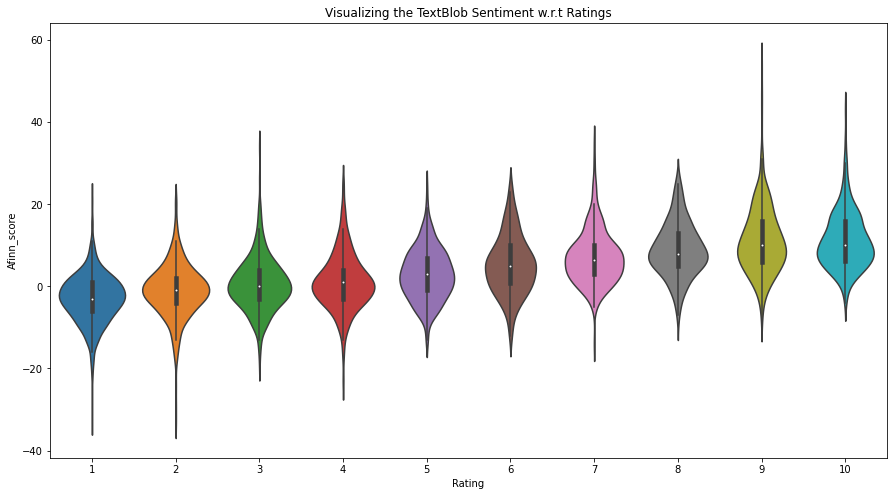

In [ ]:
#Visualizing the Afinn Sentiment Analysis

plt.figure(figsize=(15,8))

ax = sns.violinplot(data= data1, x = 'Rating', y = 'Afinn_score')

plt.title("Visualizing the TextBlob Sentiment w.r.t Ratings")

plt.show()

##### Note:
* As we can see from above, top rated reviews min Afinn score is negative, and bottom rated reviews highest afinn score is positive.
* Hence, afinn is not a better score than previously rule based sentiment analysis, but unable to segregate between lowest and highest review.

Thank you!!